In [48]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Conv2DTranspose, concatenate
from keras.models import Sequential, Model
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image
from PIL import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## part1. 자료 load 및 확인
- 자료준비:  7월25일 강의자료의  'pfcn.npz' 자료를 준비

#### [미션1-1]
- pfcn.npz 파일을  로드하고 train의 이미지,test의 이미지 자료 할당
- train과 test의 이미지를 한개의  y값으로 제작

In [49]:
# 데이터 불러오고 train과 test에 값 할당
data = np.load('.npzs/pfcn.npz')

print(list(data))

train_images = data['train_images']
test_images = data['test_images']
train_mattes = data['train_mattes']
test_mattes = data['test_mattes']

['train_images', 'test_images', 'train_mattes', 'test_mattes']


In [50]:
# train_image와 test_image 의 shpae 확인
np.shape(train_images), np.shape(test_images), np.shape(
    train_mattes), np.shape(test_mattes)

((1700, 100, 75, 3), (300, 100, 75, 3), (1700, 100, 75), (300, 100, 75))

In [51]:
# train_image와 test_image 값 한개의 y로 제작
y = np.concatenate([train_images, test_images])

In [52]:
# y값 shape 확인 (2000,100,75,3)
np.shape(y)

(2000, 100, 75, 3)

### [미션 1-2] y값 이미지 확인
![image.png](attachment:image.png)

Text(0.5, 1.0, 'y[1700]')

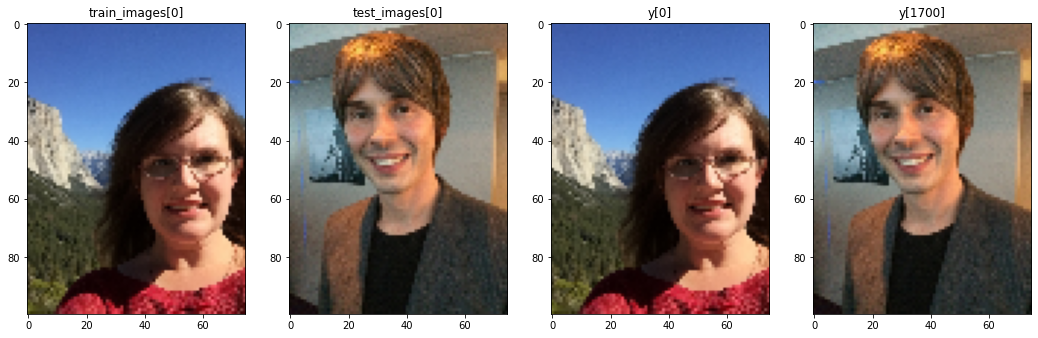

In [53]:
##  y[0] 과 y[1700] 이미지 출력

plt.figure(figsize=(18, 10))

plt.subplot(1, 4, 1)
plt.imshow(train_images[0])
plt.title('train_images[0]')

plt.subplot(1, 4, 2)
plt.imshow(test_images[0])
plt.title('test_images[0]')

plt.subplot(1, 4, 3)
plt.imshow(y[0])
plt.title('y[0]')

plt.subplot(1, 4, 4)
plt.imshow(y[1700])
plt.title('y[1700]')

## part2. x값 제작
- 100,75,3 의 y값을 50,37,3 의 x값으로 제작 하여 shape 확인 
    -x 출력 결과 (2000,50, 37, 3, 3)

In [54]:
x = resize(y, (2000, 50, 37, 3))
np.shape(x)

(2000, 50, 37, 3)

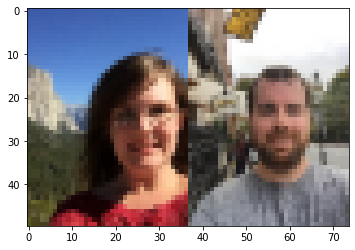

In [55]:
plt.imshow(np.hstack(x[:2]))

## Part2. train, test 값 제작
- 20%를 test 값으로 제작
- x_train, y_train, x_test, y_test 값 제작
((1600, 50, 37, 3), (1600, 100, 75, 3), (400, 50, 37, 3), (400, 100, 75, 3))

In [56]:
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=SEED)

In [57]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 50, 37, 3), (400, 50, 37, 3), (1600, 100, 75, 3), (400, 100, 75, 3))

## Part3. 모델링 - unet 모델로 제작
- x데이터(50,37,3)을 y값(100,75,3) 될수 있도록 모델 제작 

In [58]:
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [59]:
def unet_like():
    inputs = Input((50, 37, 3))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2)(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(0, 1))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(1, 0))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0, 1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    u10 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0, 1))(c9)
    outputs = Conv2D(3, 1, activation="sigmoid")(u10)

    model = Model(inputs, outputs)

    return model

In [60]:
model_unet = unet_like()
model_unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50, 37, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 50, 37, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, 50, 37, 16)   64          conv2d_33[0][0]                  
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 50, 37, 16)   0           batch_normalization_32[0][0]     
____________________________________________________________________________________________

In [61]:
# 만든 모델에 loss는 mae, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.
model_unet.compile(loss="mae", optimizer="adam", metrics=["accuracy"])

In [69]:
# x,y값 (validation_data=(x_test, y_test)) 학습시키고 5 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.
hist = model_unet.fit(X_train,
                      y_train,
                      validation_data=(X_test, y_test),
                      epochs=5)

Epoch 1/5
50/50 [==============================] - 1s 21ms/step - loss: 0.0586 - accuracy: 0.7853 - val_loss: 0.1083 - val_accuracy: 0.7659
Epoch 2/5
50/50 [==============================] - 1s 17ms/step - loss: 0.0574 - accuracy: 0.7915 - val_loss: 0.0939 - val_accuracy: 0.7212
Epoch 3/5
50/50 [==============================] - 1s 17ms/step - loss: 0.0560 - accuracy: 0.7940 - val_loss: 0.0693 - val_accuracy: 0.7383
Epoch 4/5
50/50 [==============================] - 1s 18ms/step - loss: 0.0564 - accuracy: 0.7994 - val_loss: 0.0633 - val_accuracy: 0.7322
Epoch 5/5
50/50 [==============================] - 1s 17ms/step - loss: 0.0542 - accuracy: 0.8073 - val_loss: 0.0580 - val_accuracy: 0.7106


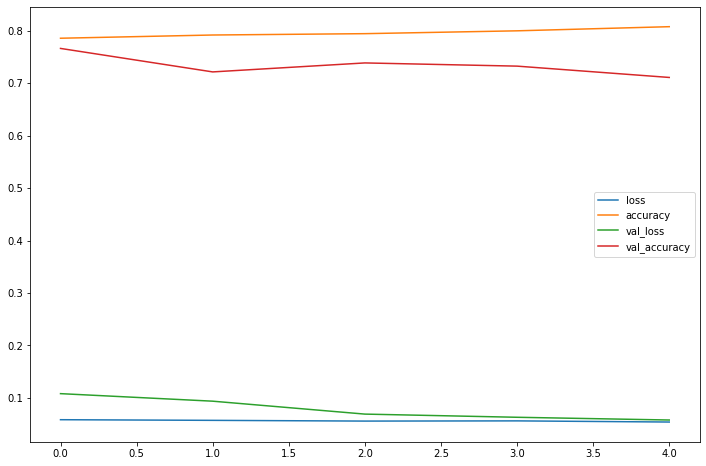

In [70]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.figure(figsize=(12, 8))
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

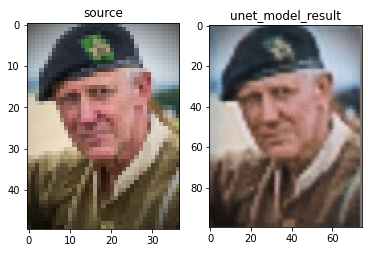

In [71]:
# 모델에 test_small_images 중 1장을 넣고 결과를 받는 코드를 작성하세요.
result = model_unet.predict(X_test[:1])

plt.subplot(1, 2, 1)
plt.title('source')
plt.imshow(X_test[0])

plt.subplot(1, 2, 2)
plt.title('unet_model_result')
plt.imshow(result[0])

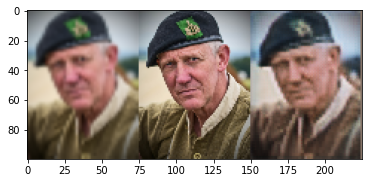

In [72]:
# np.concatenate 함수를 이용하여서 x값, y값, 모델 예측값을 출력
plt.imshow(
    np.concatenate([resize(X_test[0], (100, 75, 3)), y_test[0], result[0]],
                   axis=1))

In [73]:
# 모델을 저장하고 새파일을 열어서 새로운 사진을 넣어서 예측해봄
model_unet.save('.mpg/model/all/u-net-model.hdf5')

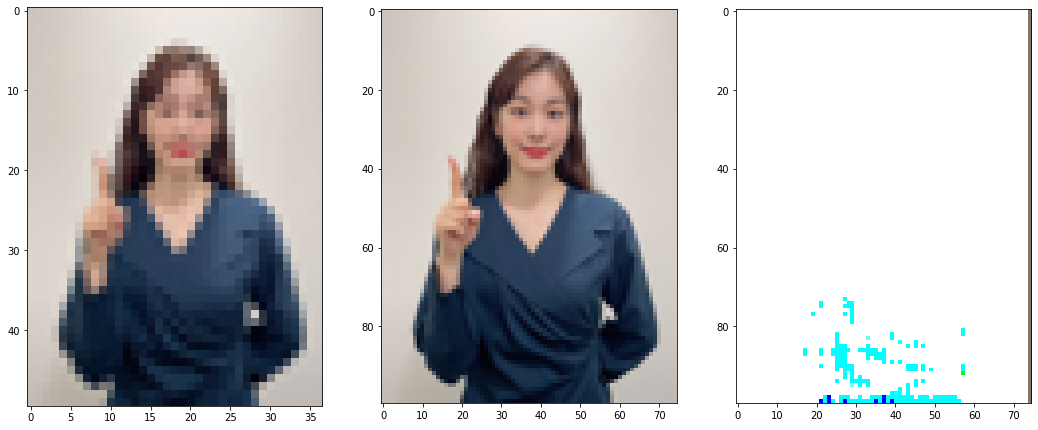

In [74]:
u_net_load_model = tf.keras.models.load_model(
    '.mpg/model/all/u-net-model.hdf5')

img = Image.open('images/kya.jpg')
img = img.resize((75, 100))
img2 = img.resize((37, 50))
x = np.array(img2)
x = x.reshape(1, 50, 37, 3)
y = np.array(img)
y = y.reshape(1, 100, 75, 3)

result = u_net_load_model.predict(x)

plt.figure(figsize=(18, 10))
plt.subplot(1, 3, 1)
plt.imshow(x[0])

plt.subplot(1, 3, 2)
plt.imshow(y[0])

plt.subplot(1, 3, 3)
plt.imshow(result[0])